In [ ]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(repo_id="wenhuic/Neuro-GPT", filename="pretrained_model/pytorch_model.bin")

In [ ]:
import torch

# Weights of the pre-trained model
model = torch.load(model_path, weights_only=False)

In [ ]:
from NeuroGPT.src.model import Model

from NeuroGPT.src.decoder.make_decoder import make_decoder
from NeuroGPT.src.decoder.unembedder import make_unembedder
from NeuroGPT.src.embedder.make import make_embedder

Model(None, make_embedder(), make_decoder(), make_unembedder()).from_pretrained(model_path)

In [ ]:
## NeuroGPT

## BrainBERT

In [1]:
import os

os.environ["BrainBERT_HOME"] = "dependencies.BrainBERT."

In [1]:

import BrainBERT as models
from omegaconf import OmegaConf
import torch

In [2]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path, weights_only=False)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream


def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)


In [3]:
ckpt_path = "../dependencies/BrainBERT_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})

model = build_model(cfg)
model.to('cuda')

init_state = torch.load(ckpt_path, weights_only=False)
load_model_weights(model, init_state['model'], False)

FileNotFoundError: [Errno 2] No such file or directory: '../dependencies/BrainBERT_weights/stft_large_pretrained.pth'

In [ ]:

import torch


def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5  #To handle boundary effects
    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb;
        pdb.set_trace()

    return f, t, Zxx

In [ ]:
import numpy as np

wav = np.load("../resources/example_wav_1.npy")
f, t, linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore",
                        return_onesided=True)  #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)


In [ ]:
out.shape  # Embedding

In [ ]:
wav.shape

In [ ]:
from VATE.contrastive_model import Contrastive_model
import torch

vate_path = "../dependencies/VATE/output/VATE/best_model_contrastive.pt"
state = torch.load(vate_path, weights_only=True)

In [ ]:
state

In [ ]:
state['embedding_text.4.weight'].shape

In [ ]:
vate_model = Contrastive_model(200, 100)
vate_model.load_state_dict(state)

In [ ]:
vate_model.eval()

In [ ]:
video = ""
vate_model.forward(video, None, None)

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath("../dependencies/VATE"))

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath("../dependencies/BrainBERT"))

In [ ]:

from omegaconf import OmegaConf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [13]:
def plot_time_series(path):
    wav = np.load(path)
    plt.figure(figsize=(10, 3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
    plt.xticks(np.arange(0, len(wav) + 1, 2048), [x / 2048 for x in np.arange(0, len(wav) + 1, 2048)])
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

In [17]:
wav = np.load("../resources/example_wav_1.npy")
wav.shape

(10240,)

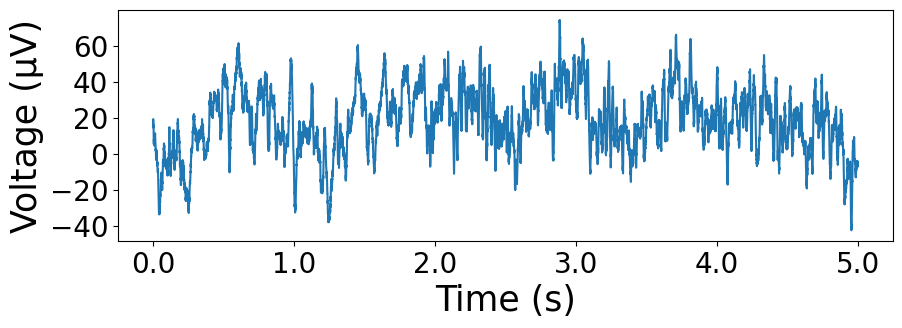

In [14]:
plot_time_series("../resources/example_wav_1.npy")

In [ ]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)

    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5  #To handle boundary effects
    if normalizing == "zscore":
        Zxx = Zxx[:, clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing == "db":
        Zxx = np.log2(Zxx[:, clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb;
        pdb.set_trace()

    return f, t, Zxx


def plot_stft(path):
    wav = np.load(path)
    f, t, linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore",
                            return_onesided=True)  #TODO hardcode sampling rate
    plt.figure(figsize=(15, 3))
    f[-1] = 200
    g1 = plt.pcolormesh(t, f, linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

In [ ]:
plot_stft("../resources/example_wav_1.npy")

In [ ]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path, weights_only=False)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream


def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [ ]:
ckpt_path = "../resources/stft_large_pretrained.pth"

In [ ]:
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to('cuda')
init_state = torch.load(ckpt_path, weights_only=False)
load_model_weights(model, init_state['model'], False)

In [ ]:
path = ""

In [ ]:
wav = np.load("../resources/example_wav_1.npy")

f, t, linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore",
                        return_onesided=True)  #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

In [ ]:
out

In [ ]:
out.shape  # Embedding

In [ ]:
wav.shape

In [ ]:
inputs.shape

In [ ]:
from scipy.io import loadmat

file = "../resources/Data_Preprocessed_P01.mat"
data_set = loadmat(file)

In [ ]:
data_set.keys()

In [ ]:
data_set['joined_data'][0][0][:, 0].shape

In [ ]:
data_set['joined_data'][0][0][0][0].shape

In [ ]:
# Devo capire meglio la storia della shape.
f, t, linear = get_stft(data_set['joined_data'][0][0][:, 0], 2048, clip_fs=40, nperseg=400, noverlap=350,
                        normalizing="zscore", return_onesided=True)  #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1, 2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

In [ ]:
out

In [ ]:
print(type(data_set['joined_data'][0][0]))
print(data_set['joined_data'][0][0].shape)
print(type(data_set['joined_data'][0][0][0, 0]))
print(data_set['joined_data'][0][0][0, 0].shape)


In [ ]:
eeg = data_set['joined_data'][0][0].T  # Shape becomes (17, 12225)

In [ ]:
# CAPTAIN TEEMO ON DUTY!
f, t, linear = get_stft(data_set['joined_data'][0][0][:, 0], 2048, clip_fs=40, nperseg=400, noverlap=350,
                        normalizing="zscore",
                        return_onesided=True)  #TODO hardcode sampling rate
plt.figure(figsize=(15, 3))

f[-1] = 200
g1 = plt.pcolormesh(t, f, linear, shading="gouraud", vmin=-3, vmax=5)

cbar = plt.colorbar(g1)
tick_font_size = 15
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
plt.xticks(fontsize=20)
plt.ylabel("")
plt.yticks(fontsize=20)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Frequency (Hz)", fontsize=20)

In [ ]:
wav = data_set['joined_data'][0][0][:, 12]
plt.figure(figsize=(10, 3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
plt.xticks(np.arange(0, len(wav) + 1, 2048), [x / 2048 for x in np.arange(0, len(wav) + 1, 2048)])
plt.xlabel("Time (s)", fontsize=25)
plt.plot(wav)